Initial data cleaning & exploration for house price prediction

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy  as np
import pandas as pd
from statsmodels.graphics.gofplots import qqplot
plt.style.use('ggplot')

In [8]:
train = pd.read_csv('../data/train.csv')
train['LogSalePrice'] = np.log1p(train['SalePrice'])
#outliers = train[ (train['GrLivArea'] > 4000) & (train['LogSalePrice'] < 13) ].index
#print(outliers)
##train.index[ train.GrLivArea > 4500 ].tolist()
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)
# train["SalePrice"] = np.log1p(train["SalePrice"])
#y = train['LogSalePrice'].reset_index(drop=True)

Int64Index([30, 88, 462, 631, 1322], dtype='int64')


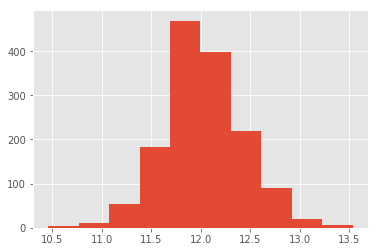

In [10]:
outliers2 = [30, 88, 462, 631, 1322]
plt.hist(train['LogSalePrice'])


      LogSalePrice  OverallQual
30       10.596660            4
88       11.350418            3
462      11.041064            5
631      11.320566            7
1322     11.898195            8


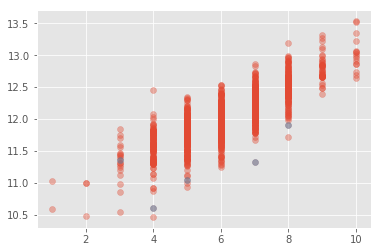

In [19]:
var = 'OverallQual'
print(train[['LogSalePrice',var]].iloc[outliers2])
plt.scatter(train[var], train['LogSalePrice'], alpha = 0.4)
plt.scatter(train[[var]].iloc[outliers2], train[['LogSalePrice']].iloc[outliers2], alpha = 0.4)

In [4]:
raw = pd.read_csv('../data/train.csv')
raw.iloc[523,:]['GrLivArea']

4676

In [5]:
raw.shape

(1460, 81)

In [8]:
raw.YrSold.value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [ ]:
raw.head()

In [ ]:
mv_bycol = pd.DataFrame( raw.isnull().sum(axis=0), columns = ['num_mv'])
mv_bycol['pct_mv'] = mv_bycol['num_mv']/raw.shape[0]
mv_bycol = mv_bycol.sort_values('num_mv', ascending=False)
mv_bycol[mv_bycol['num_mv'] > 0]

In [ ]:
# fill values where clearly NA should be None or 0
clean = raw.copy()
clean.loc[ clean['Alley'].isnull(), ['Alley'] ] = 'None'
print(clean['Alley'].value_counts())
clean.groupby('Alley').SalePrice.agg('mean')  

In [ ]:
clean.loc[ clean['PoolQC'].isnull(), ['PoolQC'] ] = 'None'
clean['PoolQC'].value_counts()
clean.groupby('PoolQC').SalePrice.agg('mean')  

In [ ]:
clean.loc[ clean['BsmtQual'].isnull(), ['BsmtQual'] ] = 'None'
print(clean['BsmtQual'].value_counts())
clean.loc[ clean['BsmtCond'].isnull(), ['BsmtCond'] ] = 'None'
clean.loc[ clean['BsmtFinType1'].isnull(), ['BsmtFinType1'] ] = 'None'
# BsmtExposure, NA means not applicable
# 

In [ ]:
mv_byrow = raw.isnull().sum(axis = 1)
mv_byrow.describe()  # each record has on average 4 to 5 missing values?

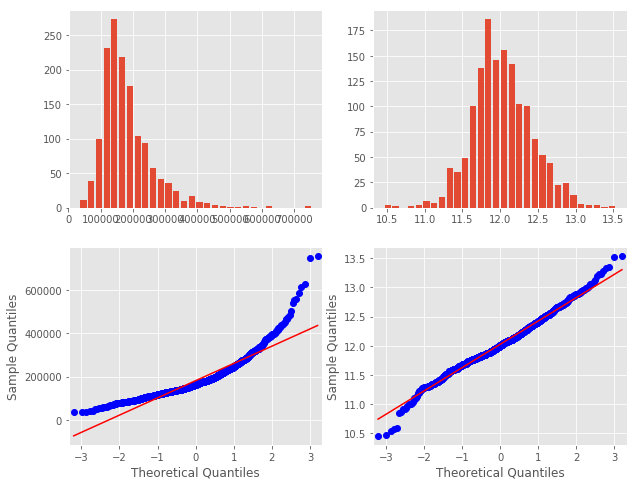

In [9]:
# transform by log(1+X)
fig = plt.figure(figsize = (10,8))
plt.subplot(2,2,1)
plt.hist(raw['SalePrice'], bins = 30, rwidth = 0.8)
plt.subplot(2,2,2)
plt.hist(np.log(raw['SalePrice']), bins = 30, rwidth = 0.8)
ax1 = fig.add_subplot(223)
qqplot(raw['SalePrice'],line='s', ax = ax1)
ax2 = fig.add_subplot(224)
qqplot(np.log(raw['SalePrice']), line = 's', ax = ax2)
plt.show()

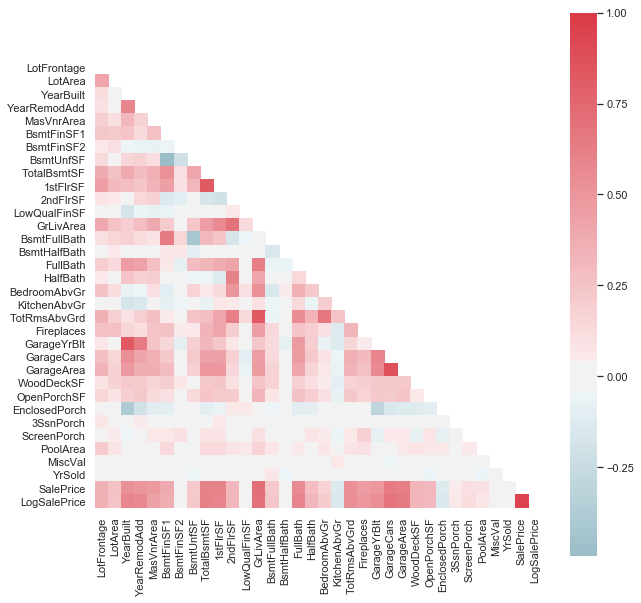

In [10]:
# Continuous features 
con_var = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
           'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
           'GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
           'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea',
           'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
           'MiscVal','YrSold','SalePrice']
raw['LogSalePrice'] = np.log(raw['SalePrice'])
con_var.append('LogSalePrice') 
#raw = raw.drop('SalePrice',axis = 1)
# con_var = con_var.drop('SalePrice')

cormat = raw[con_var].corr()

sns.set(style="white")
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(cormat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (10,10))
sns.heatmap(cormat, mask = mask, cmap = cmap, center = 0, cbar=True, square = True, fmt = '.2f')

In [ ]:
# highly correlated features
cols = cormat.columns
c0 = 0.6
for i in range(1,cormat.shape[0]-2):
    for j in range(i+1,cormat.shape[0]-2):
        if cormat.iloc[i,j] > c0:
            print("(",cols[i],",",cols[j],")",":", cormat.iloc[i,j])

Implication
GarageYrBlt: can use YearBuilt or YearRemodAdd to impute
GarageCars, GarageArea: keep one only?
Some of the SF variables may be combined?

In [ ]:
# Feature correlation with price
r_price = cormat[['SalePrice','LogSalePrice']].sort_values('SalePrice',ascending = False)
r_price[2:]

In [ ]:
# Histrograms
plt.figure(figsize = (16,9*3))
for i, v in enumerate(con_var[0:len(con_var)-1]):
    plt.subplot(9,4,i+1)
    plt.hist(raw[v].dropna(), bins = 30, rwidth = 0.8)  # important to dropna, or will error out
    plt.xlabel(v)
plt.tight_layout()
plt.show()

In [ ]:
# scatterplot of continuous vars with response

### Variables that may need transformation for better normality
- LotFrontage, GrLivArea and the other SF vars 
https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

In [ ]:
# variables with large number of 0 values
chk_var = ['ScreenPorch', 'BsmtFinSF1',]
print(np.sum(raw.ScreenPorch == 0))
print(np.sum(raw.BsmtFinSF1 == 0))

In [ ]:
zero_cnts = raw[con_var].apply(lambda x: np.sum(x == 0))
zero_cnts.sort_values(ascending=False)

In [ ]:
# are the porch vars mutually exclusive?
porch_var = ['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']
porch_data = raw[porch_var]
for v in porch_var:
    porch_data.loc[ porch_data[v] > 0, [v] ] = 1
porch_data.groupby(porch_var).EnclosedPorch.agg(['count'])
# only one type of porch available per house
# Open Porch and Wood Deck has the highest correlation with outcome variables, consider only keep these 2

In [ ]:
# bar for all categorical variables
# plt.figure(figsize = (9,9))
# for j, w in enumerate(catvars):
#     plt.subplot(3,3,j+1)
#     ncbirths[w].value_counts().plot(kind='bar')
#     plt.xlabel(w)
# plt.show()

# boxplot
fig = plt.figure(figsize=(15, 9))
sns.boxplot(y=raw['LogSalePrice'], x=raw['Neighborhood'])
plt.show()

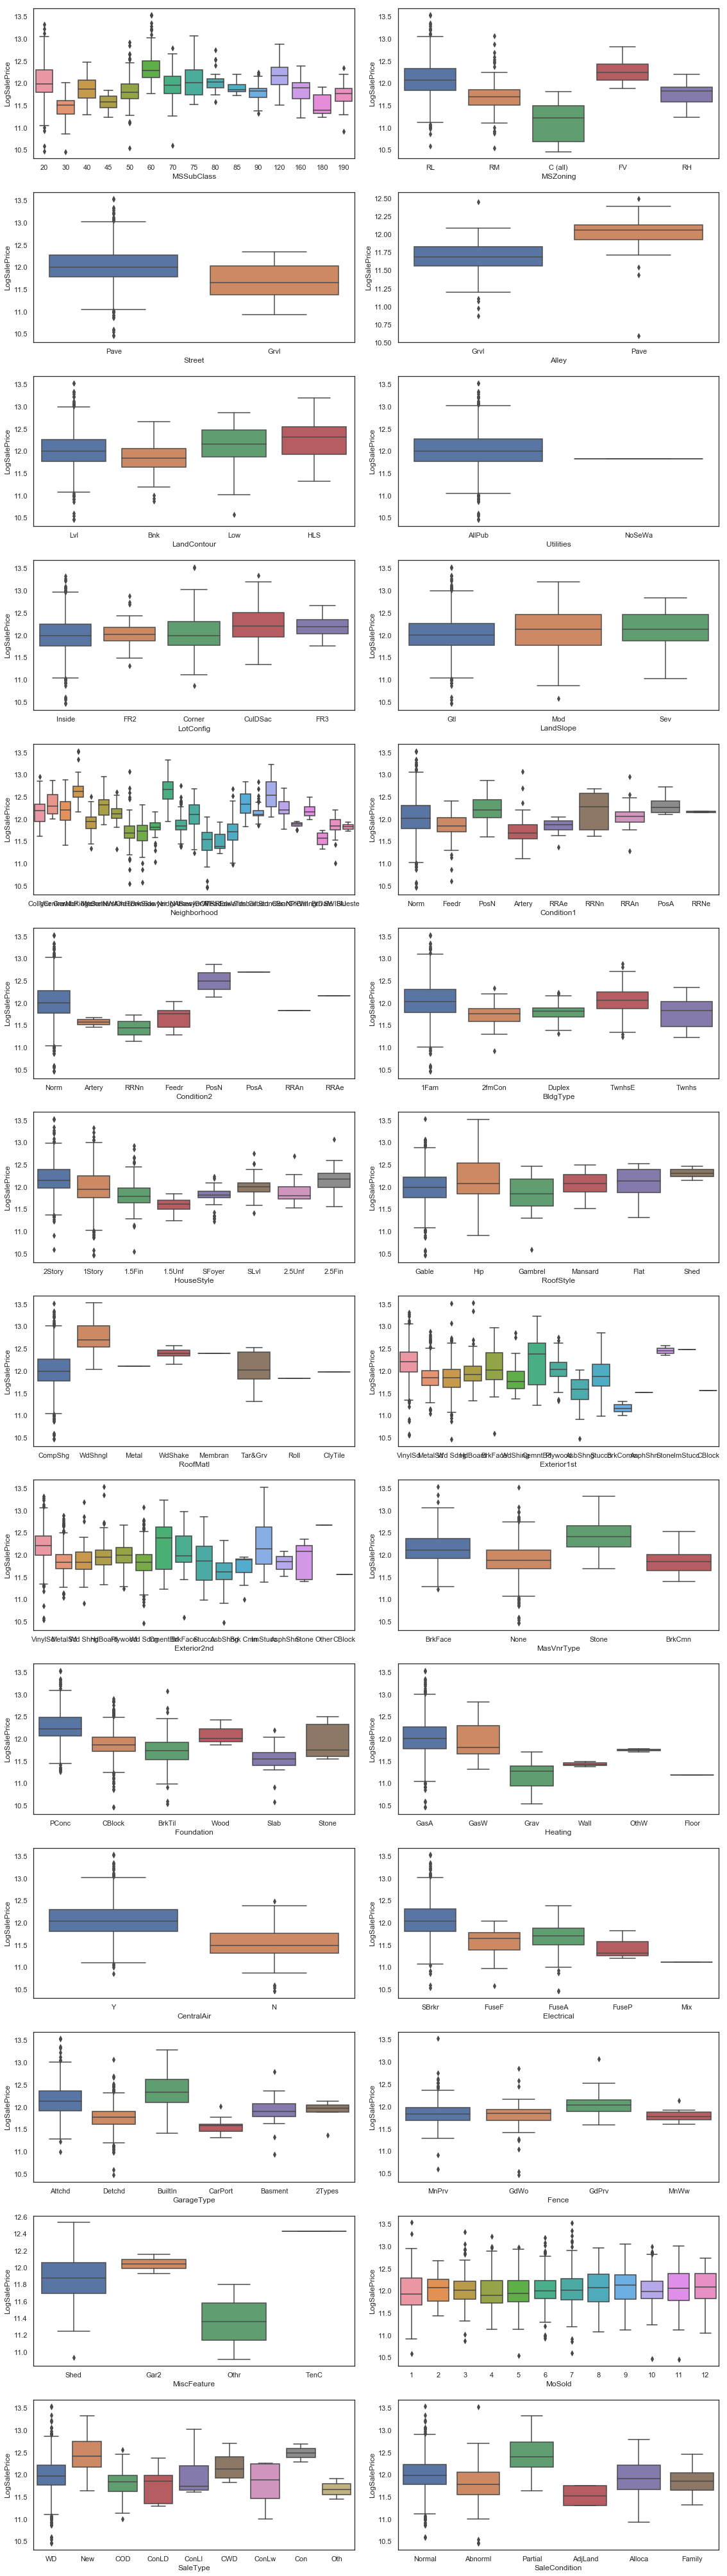

<Figure size 432x288 with 0 Axes>

In [11]:
cat_var = ['MSSubClass','MSZoning','Street','Alley','LandContour','Utilities','LotConfig','LandSlope',
           'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl',
           'Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','CentralAir','Electrical',
           'GarageType','Fence','MiscFeature','MoSold','SaleType','SaleCondition']
len(cat_var)
fig = plt.figure(figsize=(16, 56))

for i, v in enumerate(cat_var[0:len(con_var)]):
    plt.subplot(14,2,i+1)
    sns.boxplot(y=raw['LogSalePrice'], x=raw[v])  # important to dropna, or will error out
    plt.xlabel(v)
    
plt.tight_layout()
plt.show()
plt.savefig("catvar_boxplots.png")

In [ ]:
np.sum( raw['YearBuilt'] != raw['YearRemodAdd'])

In [ ]:
# raw['Age'] = raw[['YearBuilt']
raw['LotShape'].value_counts()

In [ ]:
raw['PricePerLotArea'] = raw['SalePrice']/raw['LotArea']
fig = plt.figure(figsize=(15, 9))
sns.boxplot(y=raw['PricePerLotArea'], x=raw['LotShape'])
plt.show()

In [ ]:
len(con_var)

In [ ]:
# scatterplot of continuous variables vs. LogSaleprice
plt.figure(figsize = (16,17*5))
for i, v in enumerate(con_var[0:len(con_var)-2]):
    plt.subplot(17,2,i+1)
    sns.regplot(x = raw[v], y = raw['LogSalePrice'], scatter_kws={'s':2, 'alpha':0.3})  # important to dropna, or will error out
    plt.xlabel(v)
    plt.ylabel('LogSalePrice')
plt.tight_layout()
plt.show()

In [7]:
# Outlier with GrLivArea
outliers = raw[ (raw['GrLivArea'] > 4000) & (raw['LogSalePrice'] < 13) ]
pd.set_option('display.max_columns', 90)
outliers
# Also showing as outliers on LotArea, 1stFlrSF, TotalBsmtSF

NameError: name 'raw' is not defined

In [ ]:
outliers['TotalBsmtSF']

In [ ]:
raw['LotShape'].value_counts()

In [ ]:
ord_var = ['LotShape','OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond',
           'BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional',
           'FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC']

for i, v in enumerate(ord_var):
    print(v, ":", raw[v].value_counts(),"\n")  # note this does not count NAs

In [ ]:
# ExteriorQual and ExteriorCond

# Bathroom variables
bath_var = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','LogSalePrice']
bath_data = raw[bath_var]
bath_data['TotBath'] = bath_data['BsmtFullBath'] + bath_data['BsmtHalfBath'] + bath_data['FullBath'] + bath_data['HalfBath']
bath_data.corr()

In [ ]:
LotFrontage = raw.groupby(['Neighborhood'])[['LotFrontage']]

In [ ]:
raw['Neighborhood'].value_counts()

In [ ]:
raw['Street'].value_counts()

In [ ]:
raw.groupby(['ExterQual','MasVnrType']).ExterQual.agg(['count'])

In [ ]:
raw['PavedDrive'].value_counts()

In [6]:
raw['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64